In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
data=pd.read_csv('UNRATE.csv',header=None)
data.head()

,0,1
0,01-01-1948,3.4
1,01-02-1948,3.8
2,01-03-1948,4.0
3,01-04-1948,3.9
4,01-05-1948,3.5


In [57]:
data.columns = ['Date','Unrate']
data['Date'] = pd.to_datetime(data['Date'],format='%d-%m-%Y')
data=data.set_index('Date')
data.head()

,Unrate
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


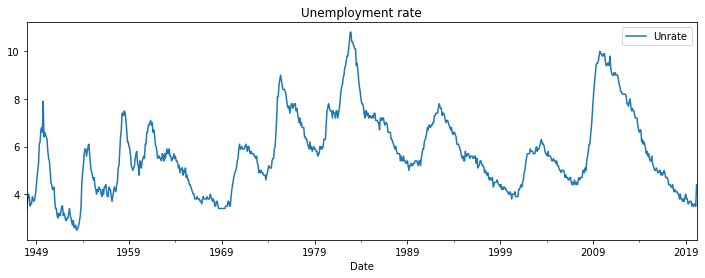

In [58]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Unemployment rate')
plt.show(block=False)

In [59]:
train_len = 612
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

In [60]:
data.Unrate.isna().sum()

0

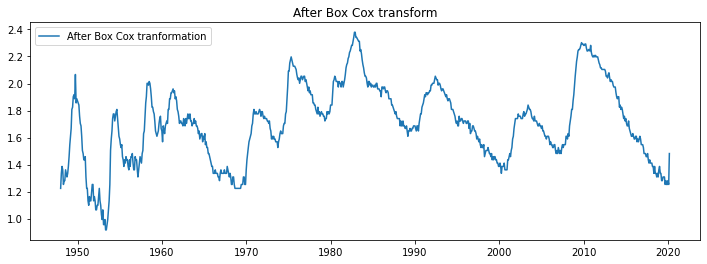

In [61]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Unrate'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [62]:
data_boxcox.isna().sum()

0

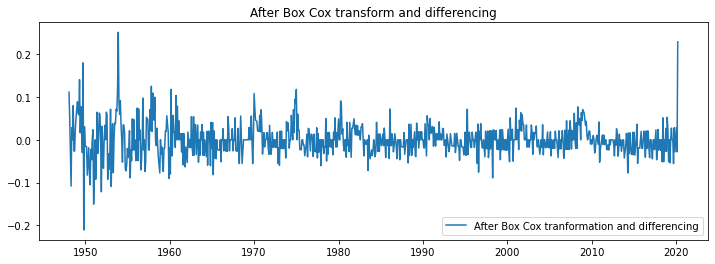

In [63]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [64]:
data_boxcox_diff.isna().sum()

1

In [65]:
data_boxcox_diff.dropna(inplace=True)

In [66]:
data_boxcox_diff.shape

(866,)

In [67]:
train_len=612
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [68]:
train_data_boxcox.isna().sum()

0

In [69]:
test_data_boxcox.isna().sum()

0

In [70]:
train_data_boxcox_diff.isna().sum()

0

In [71]:
train_data_boxcox_diff

Date
1948-02-01    0.111226
1948-03-01    0.051293
1948-04-01   -0.025318
1948-05-01   -0.108214
1948-06-01    0.028171
                ...   
1998-08-01    0.000000
1998-09-01    0.021979
1998-10-01   -0.021979
1998-11-01   -0.022473
1998-12-01    0.000000
Length: 611, dtype: float64

In [72]:
test_data_boxcox_diff.isna().sum()

0

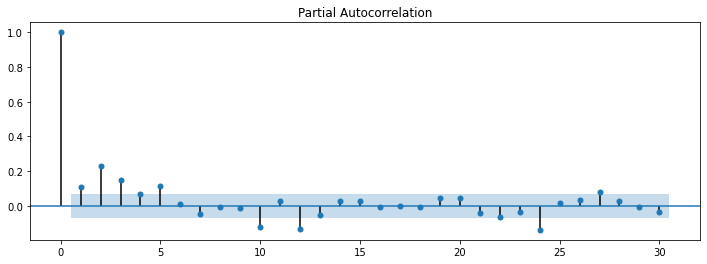

In [73]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [74]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const       0.000466
ar.L1.y     0.060690
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090456
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047125
ar.L12.y   -0.148533
dtype: float64


In [75]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

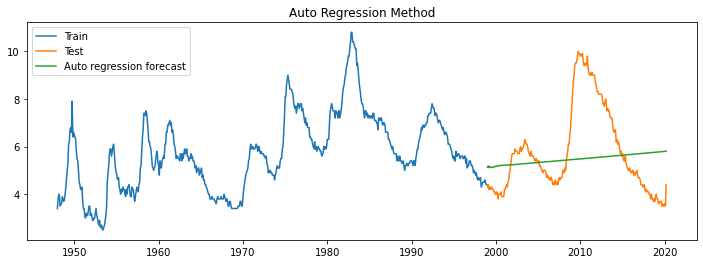

In [76]:
plt.figure(figsize=(12,4))
plt.plot(train['Unrate'], label='Train')
plt.plot(test['Unrate'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [77]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_ar['ar_forecast'][test.index.min():])/test['Unrate'])*100,2)

results = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape]})
results = results[['Method', 'RMSE', 'MAPE']]
results


,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62


In [79]:
pd.set_option('display.max_rows', 500)

In [82]:
y_hat_ar['ar_forecast']['1948-06-01']

4.210203485201313

In [83]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


In [84]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

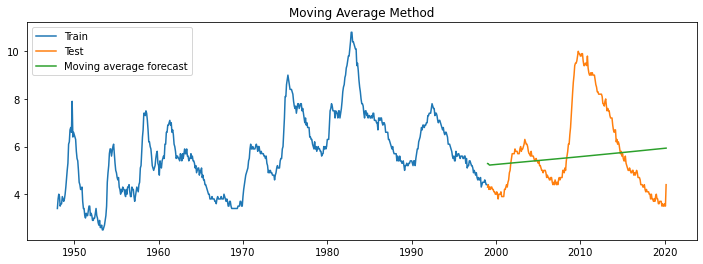

In [85]:
plt.figure(figsize=(12,4))
plt.plot(data['Unrate'][:train_len], label='Train')
plt.plot(data['Unrate'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [86]:
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_ma['ma_forecast'][test.index.min():])/test['Unrate'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Moving Average (MA) method,1.82,24.26


In [88]:
y_hat_ma['ma_forecast']['1948-06-01']

4.1415267157489115

In [89]:
model = ARIMA(train_data_boxcox, order=(12, 1, 5))
model_fit = model.fit()
print(model_fit.params)

const         0.000453
ar.L1.D.y    -0.254670
ar.L2.D.y     0.770406
ar.L3.D.y     0.582996
ar.L4.D.y    -0.516075
ar.L5.D.y    -0.675331
ar.L6.D.y     0.060899
ar.L7.D.y     0.051496
ar.L8.D.y     0.099735
ar.L9.D.y     0.165447
ar.L10.D.y   -0.041102
ar.L11.D.y   -0.034284
ar.L12.D.y   -0.048920
ma.L1.D.y     0.284238
ma.L2.D.y    -0.606843
ma.L3.D.y    -0.434888
ma.L4.D.y     0.570918
ma.L5.D.y     0.740150
dtype: float64


In [90]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

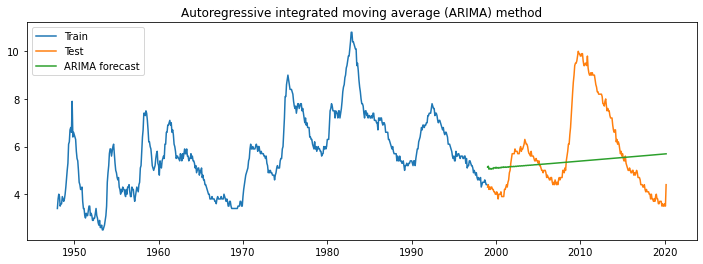

In [91]:
plt.figure(figsize=(12,4))
plt.plot(train['Unrate'], label='Train')
plt.plot(test['Unrate'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

In [92]:
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_arima['arima_forecast'][test.index.min():])/test['Unrate'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Moving Average (MA) method,1.82,24.26
0,Autoregressive integrated moving average (ARIM...,1.85,23.16


In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(2, 1, 4), seasonal_order=(2, 1, 4, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.607955
ar.L2       0.118793
ma.L1      -0.567886
ma.L2      -0.012593
ma.L3       0.071917
ma.L4       0.049717
ar.S.L12   -0.959726
ar.S.L24   -0.525832
ma.S.L12   -0.261113
ma.S.L24   -0.550521
ma.S.L36   -0.415340
ma.S.L48    0.278246
sigma2      0.001488
dtype: float64


In [98]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

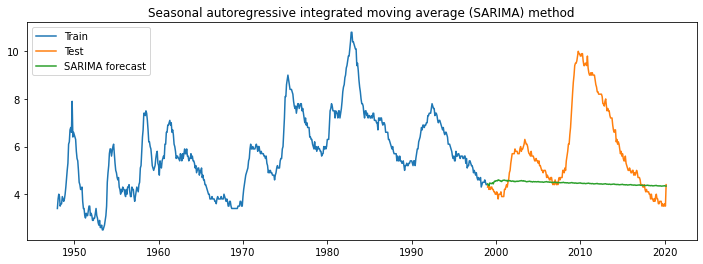

In [99]:
plt.figure(figsize=(12,4))
plt.plot(train['Unrate'], label='Train')
plt.plot(test['Unrate'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [100]:
rmse = np.sqrt(mean_squared_error(test['Unrate'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Unrate']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Unrate'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,1.83,23.62
0,Moving Average (MA) method,1.82,24.26
0,Autoregressive integrated moving average (ARIM...,1.85,23.16
0,Seasonal autoregressive integrated moving aver...,2.25,22.52
0,Seasonal autoregressive integrated moving aver...,2.23,21.91
